# Using a Keras Sequential Model to Identify Buildings from Satellite Imagery
By Philip Harman

In [1]:
# Import libraries
import imageio
import matplotlib.pyplot as plt
from skimage.io import imshow
import skimage
import skimage.transform
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import tensorflow as tf
import py7zr
sns.set()

/home/philipharman/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Functions Used

In [2]:
# Import raw datasets
def img_imp(name):
    path = "datasets/"+name+'.npy'
    return np.load(path)

# Normalize matrix [0:1]
def norm(mat):
    mat_max = mat.max()
    mat_min = mat.min()
    new_mat = (mat - mat_min) / (mat_max - mat_min)
    return new_mat

# Flatten a 3D Matrix to 2D 
def flatten_3D_matrix(mat):
    mat_len = mat.shape[0]*mat.shape[1]
    mat_flat = mat.reshape(mat_len , mat.shape[2])
    return mat_flat

# Flatten a 2D matrix to 1D
def flatten_2D_matrix(mat):
    mat_len = mat.shape[0]*mat.shape[1]
    mat_flat = mat.reshape(mat_len)
    return mat_flat

# Prep label matrix (Change to binary, remove some noise)
def prep_labels(mat):
    mat_new = mat.copy()
    mat_new[mat < 30000] = 0
    mat_new[mat >= 30000] = 1
    return mat_new

# Feature prep: Calculate NDVI + Moisture index, then resize + stack features
def prep_features():
    # Calculate NDVI + Moisture Index,  Stack rgb
    ndvi = np.true_divide((ir - r), (ir + r))
    mstr = np.true_divide((ir - SWIR1), (ir + SWIR1))
    rgb = np.dstack((r, g, b))
    
    # Resize features to match Label matrix
    rgb_big = skimage.transform.resize(rgb, output_shape=(pan.shape[0],pan.shape[1],3), order=3, mode='constant', cval=0.0)
    ir_big = skimage.transform.resize(ir, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0) 
    coast_big = skimage.transform.resize(coast, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0)  
    ndvi_big = skimage.transform.resize(ndvi, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0) 
    mstr_big = skimage.transform.resize(mstr, output_shape=(pan.shape[0],pan.shape[1]), order=3, mode='constant', cval=0.0) 
    
    # Sharpen RGB using Panchromatic band
    hsv = skimage.color.rgb2hsv(rgb_big)   
    hsv[...,2]=pan                     
    rgb_sharp = skimage.color.hsv2rgb(hsv)   
    
    # Stack all [r, g, b, ir, coast, ndvi, moisture]
    features = np.dstack((rgb_sharp, ir_big, coast_big, ndvi_big, mstr_big))
    return features

In [3]:
# Unzip pan band
with py7zr.SevenZipFile('datasets/pan.7z', mode='r') as pan: 
    pan.extractall("datasets/pan") 

In [4]:
# Import raw datasets
r = norm( img_imp('red') )
g = norm( img_imp('green') )
b = norm( img_imp('blue') )
ir = norm( img_imp('ir') )
coast = norm( img_imp('coast') )
SWIR1 = norm( img_imp('SWIR1') )
pan = img_imp('pan/pan')
labels = prep_labels ( img_imp('label') )

In [5]:
# Prep features [r, g, b, ir, coast, ndvi, moisture]
features = prep_features()

# Building the Model

In [7]:
# ALL FEATURES = [r, g, b, ir, coast, ndvi, moisture]
full = pd.DataFrame(flatten_3D_matrix(features))
full['Labels'] = flatten_2D_matrix(labels[:,:])
full.columns = ['R','G','B','IR','Coast','NDVI','MSTR','Labels']
full

,R,G,B,IR,Coast,NDVI,MSTR,Labels
0,0.098628,0.104524,0.061066,0.143381,0.014068,0.428760,0.176044,1
1,0.095327,0.102693,0.057303,0.194299,0.017213,0.586812,0.249704,1
2,0.091708,0.102678,0.051127,0.189286,0.013054,0.583313,0.265625,1
3,0.095588,0.105669,0.052175,0.193833,0.012841,0.574130,0.272880,1
4,0.102579,0.106630,0.058546,0.207877,0.016568,0.559093,0.271351,1
...,...,...,...,...,...,...,...,...
7639762,0.111498,0.101662,0.074923,0.174729,0.040050,0.380780,-0.032293,1
7639763,0.112169,0.100497,0.076402,0.169966,0.042919,0.356042,-0.049619,1
7639764,0.111009,0.097884,0.074668,0.175597,0.044350,0.361666,-0.042501,1
7639765,0.110796,0.096248,0.071819,0.191693,0.044346,0.397827,-0.010861,1


In [8]:
######################################################################## TOGGLE FEATURES HERE
drop = ['R','G','B','Coast'] # These features will be dropped from the model
########################################################################
selected = full.drop(columns = drop)
selected

,IR,NDVI,MSTR,Labels
0,0.143381,0.428760,0.176044,1
1,0.194299,0.586812,0.249704,1
2,0.189286,0.583313,0.265625,1
3,0.193833,0.574130,0.272880,1
4,0.207877,0.559093,0.271351,1
...,...,...,...,...
7639762,0.174729,0.380780,-0.032293,1
7639763,0.169966,0.356042,-0.049619,1
7639764,0.175597,0.361666,-0.042501,1
7639765,0.191693,0.397827,-0.010861,1


In [9]:
# Train/Test Split (4000 / 1000)
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

xtrain, xtest, ytrain, ytest = train_test_split(
    selected.drop(columns = ['Labels']),
    full.Labels,
    train_size = 4000, test_size = 1000,
    random_state = 42)

In [10]:
# Model Setup
import keras
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

# Make Y variables categorical
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

# Model layer definitions
model = Sequential()
model.add(Dense(500, activation='relu', input_dim = xtrain.shape[1]))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))    

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fit
model.fit(xtrain, ytrain, epochs=20)

Epoch 1/20
125/125 [==============================] - 1s 2ms/step - loss: 0.4925 - accuracy: 0.8138
Epoch 2/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3989 - accuracy: 0.8044
Epoch 3/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3602 - accuracy: 0.8114
Epoch 4/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8119
Epoch 5/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3625 - accuracy: 0.8129
Epoch 6/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8072
Epoch 7/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3512 - accuracy: 0.8291
Epoch 8/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8220
Epoch 9/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3630 - accuracy: 0.8175
Epoch 10/20
125/125 [==============================] - 0s 2ms/step - loss: 0.3627 - accuracy: 0.8103

In [11]:
# Evaluate Model
pred_train= model.predict(xtrain)
scores = np.round(model.evaluate(xtrain, ytrain, verbose=0)[1]*100,2)
print('Accuracy / Error on train data: {} / {}%'.format(scores, np.round(100 - scores),2))   
 
pred_test= model.predict(xtest)
scores2 = np.round(model.evaluate(xtest, ytest, verbose=0)[1]*100,3)
print('Accuracy / Error on test data: {} / {}%'.format(scores2, np.round(100 - scores2,2))) 

Accuracy / Error on train data: 82.75 / 17.0%
Accuracy / Error on test data: 81.7 / 18.3%


In [10]:
# Export model
model_json = model.to_json()
with open("model/model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model/model.h5")

# Displaying Results

In [11]:
# Full Prediction (caution - this may take a few minutes)
predicted_image = model.predict(selected.drop(columns = 'Labels'))[:,1]

In [7]:
# Pictures for reference
full_rgb = features[:,:,0:3]*2.5
med_rgb = full_rgb[1500:2000,1500:2000,:]
sm_rgb_1 = med_rgb[100:200,0:100]
sm_rgb_2 = med_rgb[300:400,100:200]

full_labels = labels.copy()
med_lab = full_labels[1500:2000,1500:2000]
sm_lab_1 = med_lab[100:200,0:100]
sm_lab_2 = med_lab[300:400,100:200]

full_pred = predicted_image.reshape(labels.shape)
med_pred = full_pred[1500:2000,1500:2000]
sm_pred_1 = med_pred[100:200,0:100]
sm_pred_2 = med_pred[300:400,100:200]

In [13]:
def lil_plachty(rgb, label, pred, title, w, h):
    fig, ax = plt.subplots(1, 3, figsize=(w, h))
    
    ax[0].imshow( rgb )
    ax[1].imshow( label )
    ax[2].imshow( pred )
    
    ax[0].set_title('RGB', size = 20)
    ax[1].set_title('Labels', size = 20)
    ax[2].set_title('Predicted', size = 20)

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    
    fig.suptitle(title, size = 25)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


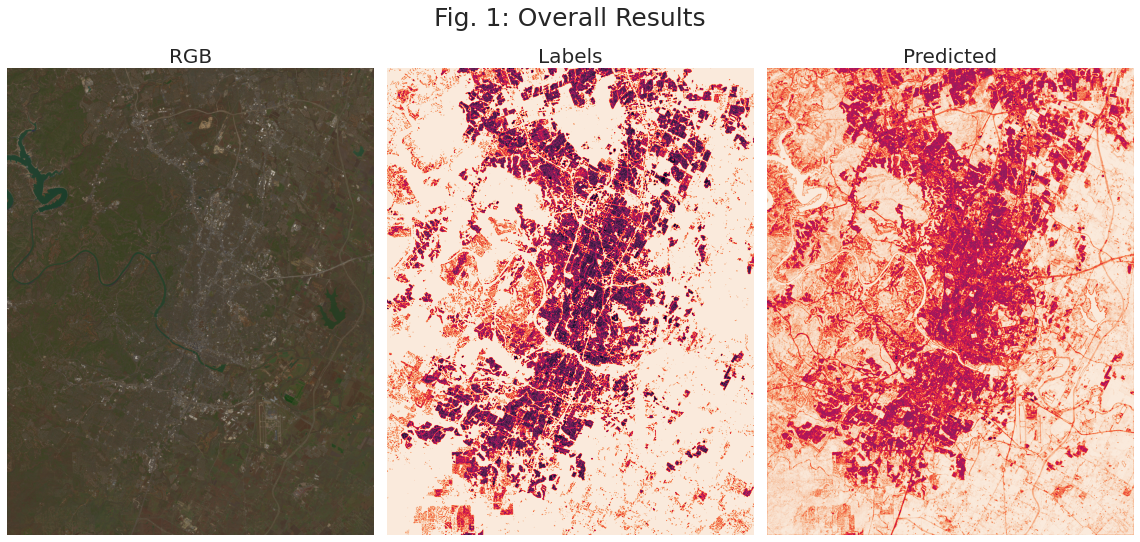

In [14]:
lil_plachty(full_rgb, full_labels, full_pred, 'Fig. 1: Overall Results', 16, 8)
plt.savefig('images/fig1.png')

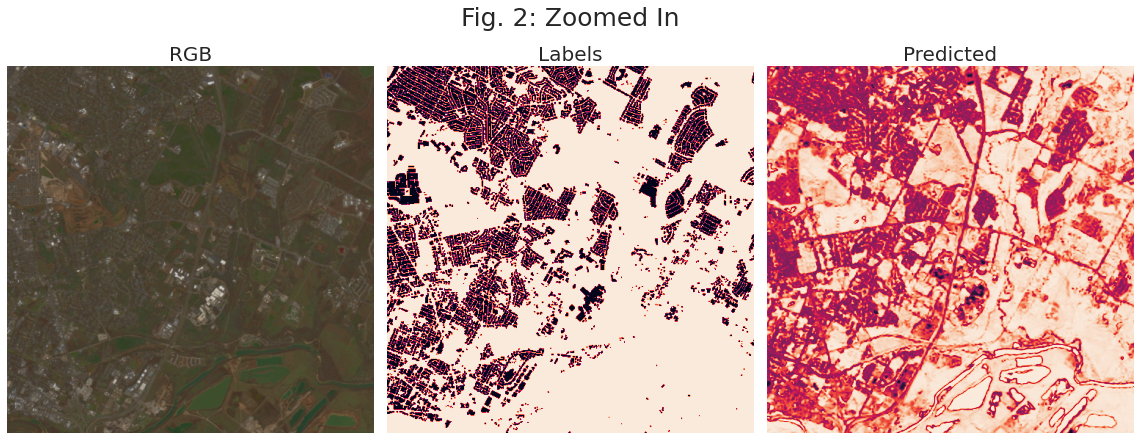

In [15]:
lil_plachty(med_rgb, med_lab, med_pred, 'Fig. 2: Zoomed In', 16, 6.5)
plt.savefig('images/fig2.png')

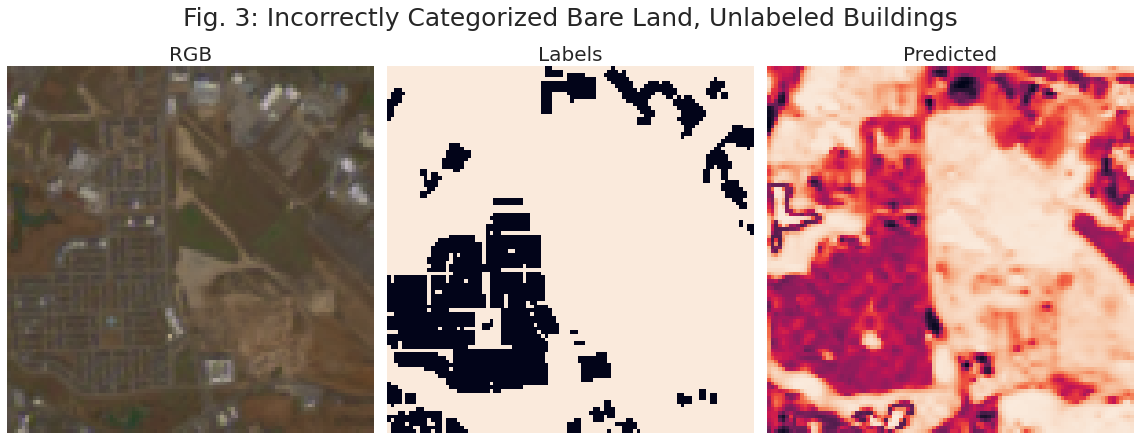

In [16]:
lil_plachty(sm_rgb_1, sm_lab_1, sm_pred_1, 'Fig. 3: Incorrectly Categorized Bare Land, Unlabeled Buildings', 16, 6.5)
plt.savefig('images/fig3.png')

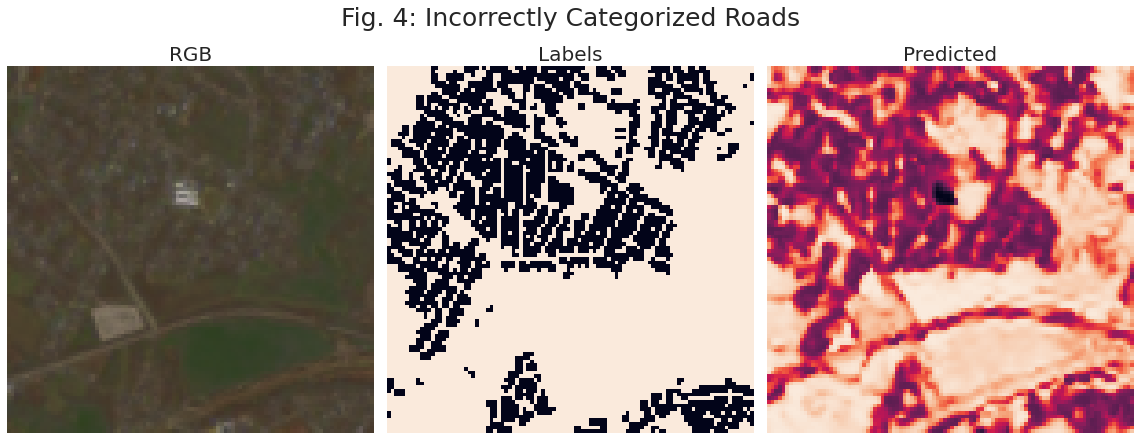

In [17]:
lil_plachty(sm_rgb_2, sm_lab_2, sm_pred_2, 'Fig. 4: Incorrectly Categorized Roads', 16, 6.5)
plt.savefig('images/fig4.png')